In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/beer-consumption-sao-paulo/Consumo_cerveja.csv


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error as MSE


In [2]:
df = pd.read_csv('/kaggle/input/beer-consumption-sao-paulo/Consumo_cerveja.csv')

## 1. EDA on Data

In [5]:
display(df.head())
display(df.describe())
display(df.info)
display(df.columns)
display(df.tail())

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
4,2015-01-05,"23,82",21,"28,3",0,0.0,28.900


,Final de Semana,Consumo de cerveja (litros)
count,365.000000,365.000000
mean,0.284932,25.401367
std,0.452001,4.399143
min,0.000000,14.343000
25%,0.000000,22.008000
50%,0.000000,24.867000
75%,1.000000,28.631000
max,1.000000,37.937000


<bound method DataFrame.info of            Data Temperatura Media (C) Temperatura Minima (C)  \
0    2015-01-01                  27,3                   23,9   
1    2015-01-02                 27,02                   24,5   
2    2015-01-03                 24,82                   22,4   
3    2015-01-04                 23,98                   21,5   
4    2015-01-05                 23,82                     21   
..          ...                   ...                    ...   
936         NaN                   NaN                    NaN   
937         NaN                   NaN                    NaN   
938         NaN                   NaN                    NaN   
939         NaN                   NaN                    NaN   
940         NaN                   NaN                    NaN   

    Temperatura Maxima (C) Precipitacao (mm)  Final de Semana  \
0                     32,5                 0              0.0   
1                     33,5                 0              0.0   
2   

Index(['Data', 'Temperatura Media (C)', 'Temperatura Minima (C)',
       'Temperatura Maxima (C)', 'Precipitacao (mm)', 'Final de Semana',
       'Consumo de cerveja (litros)'],
      dtype='object')

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# We are first gonna rename the columns
renamed_columns = ['Date','Average_Temperature', 'Minimum_Temperature','Maximum_Temperature','Precipitation','End_of_Week','Consumption']
df.columns = renamed_columns
display(df.head())
number_of_nans = df['Date'].isnull().sum()
display(number_of_nans)

,Date,Average_Temperature,Minimum_Temperature,Maximum_Temperature,Precipitation,End_of_Week,Consumption
0,2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
4,2015-01-05,"23,82",21,"28,3",0,0.0,28.900


576

In [12]:
# Then we are gonna check out about those nan values. How many of the values are nan. We are g
print(df.isnull().sum())
print(df['Average_Temperature'].isnull().sum())
print(df['Minimum_Temperature'].isnull().sum())

# We also got to make sure that the same entities have null values
if list(df['Date'].isnull()) == list(df['Consumption'].isnull()):
    print(True)
else:
    print(False)


Date                   576
Average_Temperature    576
Minimum_Temperature    576
Maximum_Temperature    576
Precipitation          576
End_of_Week            576
Consumption            576
dtype: int64
576
576
True


In [17]:
# Next we identify the indexes with null values and drop them. But first, lets checkout to make sure that the last indexes are 
df = df.dropna(thresh = 2)
print(len(df))
display(df.tail())

365


,Date,Average_Temperature,Minimum_Temperature,Maximum_Temperature,Precipitation,End_of_Week,Consumption
360,2015-12-27,24,"21,1","28,2","13,6",1.0,32.307
361,2015-12-28,"22,64","21,1","26,7",0,0.0,26.095
362,2015-12-29,"21,68","20,3","24,1","10,3",0.0,22.309
363,2015-12-30,"21,38","19,3","22,4","6,3",0.0,20.467
364,2015-12-31,"24,76","20,2",29,0,0.0,22.446


In [19]:
# Next up, we can see that there are comma values in Average_Temperature, Minimum_Temperature, Maximum_Temperature, and Precipitation column. Those commas should probably be decimal points and the column must be treated like a float column
df['Average_Temperature'] = df['Average_Temperature'].str.replace(',', '.')
df['Average_Temperature'] = df['Average_Temperature'].astype(float)
df['Minimum_Temperature'] = df['Minimum_Temperature'].str.replace(',','.')
df['Minimum_Temperature'] = df['Minimum_Temperature'].astype(float)
df['Maximum_Temperature'] = df['Maximum_Temperature'].str.replace(',', '.')
df['Maximum_Temperature'] = df['Maximum_Temperature'].astype(float)
df['Precipitation'] = df['Precipitation'].str.replace(',', '.')
df['Precipitation'] = df['Precipitation'].astype(float)
display(df.tail())
display(df.describe())

,Date,Average_Temperature,Minimum_Temperature,Maximum_Temperature,Precipitation,End_of_Week,Consumption
360,2015-12-27,24.00,21.1,28.2,13.6,1.0,32.307
361,2015-12-28,22.64,21.1,26.7,0.0,0.0,26.095
362,2015-12-29,21.68,20.3,24.1,10.3,0.0,22.309
363,2015-12-30,21.38,19.3,22.4,6.3,0.0,20.467
364,2015-12-31,24.76,20.2,29.0,0.0,0.0,22.446


,Average_Temperature,Minimum_Temperature,Maximum_Temperature,Precipitation,End_of_Week,Consumption
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.226356,17.461370,26.611507,5.196712,0.284932,25.401367
std,3.180108,2.826185,4.317366,12.417844,0.452001,4.399143
min,12.900000,10.600000,14.500000,0.000000,0.000000,14.343000
25%,19.020000,15.300000,23.800000,0.000000,0.000000,22.008000
50%,21.380000,17.900000,26.900000,0.000000,0.000000,24.867000
75%,23.280000,19.600000,29.400000,3.200000,1.000000,28.631000
max,28.860000,24.500000,36.500000,94.800000,1.000000,37.937000


In [22]:
# And lastly, we probably should change the Date column to datetime index
df['Date'] = pd.to_datetime(df['Date'])

## 2. Data Visualization

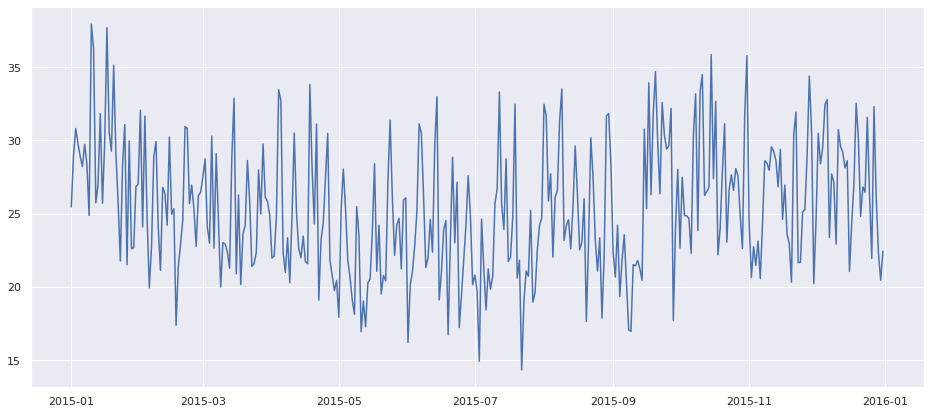

In [25]:
# First up, let's checkout the distribution of Consumption against date
sns.set()
plt.figure(figsize = (16,7))
_ = plt.plot(df['Date'], df['Consumption'])
_ = plt.show()

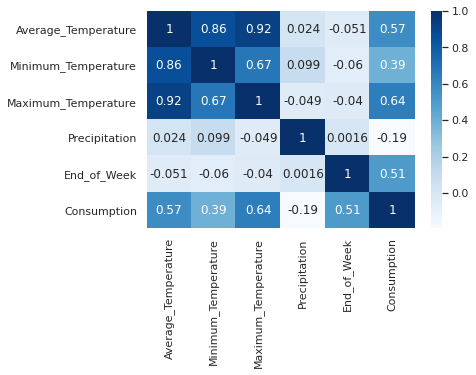

In [27]:
# Next up, let's see the correlation within variables
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot = True, cmap = 'Blues')
plt.show()

# Seems like the consumption is highly relted to Maximum_Temperature of the day, and has an inverse relation with the Precipitation levels

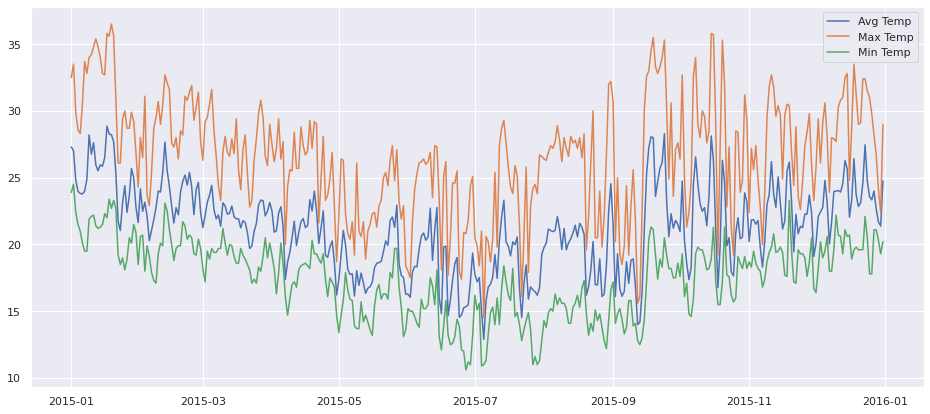

In [32]:
# Let's get a vibe of how the temperatures and percipitations vary each day
plt.figure(figsize = (16,7))
_ = plt.plot(df['Date'], df['Average_Temperature'], label = 'Avg Temp')
_ = plt.plot(df['Date'], df['Maximum_Temperature'], label = 'Max Temp')
_ = plt.plot(df['Date'], df['Minimum_Temperature'], label = 'Min Temp')
# _ = plt.plot(df['Date'], df['Precipitation'], label = 'Prec')
plt.legend(loc = 'upper right')
_ = plt.show()

,Consumption
Date,
2015-01-01,25.461
2015-01-02,28.972
2015-01-03,30.814
2015-01-04,29.799
2015-01-05,28.900


Test Statistic                  -3.465884
p-value                          0.008908
#Lags Used                      13.000000
Number of Observations Used    351.000000
dtype: float64

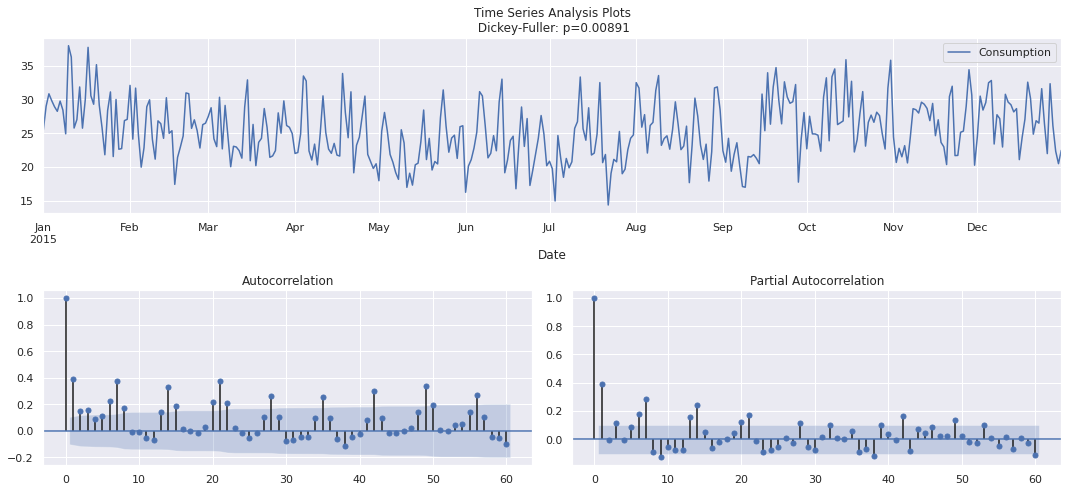

In [43]:
# Let's try to understand from the data whether time series models could be applied. We will first check for signs of trend and seasonality
def test_stationarity(y, lags=None):
    '''
        This function will plot the time series, its ACF and PACF, & calculate Augmented Dickey–Fuller test
        
        y (DataFrame) -> Actual sales timeseries. With 'Consumption' as the only column
        lags (integer) -> Indicates the number of lags to include in ACF, PACF calculation
    '''
    
    fig = plt.figure(figsize=(15,7))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=ts_ax)
    adf_test = adfuller(y.Consumption, autolag = 'AIC')
    adf_output = pd.Series(adf_test[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    display(adf_output)
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(adf_output[1]))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    
df1 = df.copy()
df1.drop(columns = ['Maximum_Temperature','Average_Temperature','Minimum_Temperature','End_of_Week','Precipitation'], inplace = True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1 = df1.set_index('Date')
display(df1.head())
test_stationarity(df1, lags = 60)

There does seem to be a significant correlation between the lag features on a weekly basis, but that's a timid correlation, and I will see if I use Time Series methods on this.
And even if we look at it logically, it is usually not the case that the Beer consumption would be dependent on consumption on previous days, and the slight seasonality we see on a weekly basis could very well be pointing towards the weekends (something our regression models can easily map)

In [44]:
display(df.head())
display(df1.head())

,Date,Average_Temperature,Minimum_Temperature,Maximum_Temperature,Precipitation,End_of_Week,Consumption
0,2015-01-01,27.30,23.9,32.5,0.0,0.0,25.461
1,2015-01-02,27.02,24.5,33.5,0.0,0.0,28.972
2,2015-01-03,24.82,22.4,29.9,0.0,1.0,30.814
3,2015-01-04,23.98,21.5,28.6,1.2,1.0,29.799
4,2015-01-05,23.82,21.0,28.3,0.0,0.0,28.900


,Consumption
Date,
2015-01-01,25.461
2015-01-02,28.972
2015-01-03,30.814
2015-01-04,29.799
2015-01-05,28.900


## 3. Data Preparation

In [ ]:
# I could add additional features from the date column like week_of_month, or month_of_year, etc. 





In [ ]:
# I can use standard scaler to normalize the data as well. I will try without it first, and then will do it if I see the need





In [50]:
# For now, I will just drop the date column, create the test train splits on the remaining data
y = df['Consumption']
X = df.drop(['Date','Consumption'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## 4. Modelling

In [53]:
model_1 = LinearRegression(normalize = True, n_jobs = -1)
model_1.fit(X_train, y_train)
y_pred_1_train = model_1.predict(X_train)
y_pred_1 = model_1.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred_1)
mse_1 = MSE(y_test, y_pred_1)
rmse_1 = mse_1 ** 0.5

In [54]:
grid_dt = {'max_depth':[5,7,9], 'min_samples_leaf': [3,5,7]}
dt = DecisionTreeRegressor()
grid_model = GridSearchCV(estimator = dt, param_grid = grid_dt, cv = 5, n_jobs = -1)
grid_model.fit(X_train, y_train)
model_2 = grid_model.best_estimator_
y_pred_2 = model_2.predict(X_test)
y_pred_2_train = model_2.predict(X_train)
mse_2 = MSE(y_test, y_pred_2)
rmse_2 = mse_2 ** 0.5

In [60]:
grid_rf = {'n_estimators':[50, 100, 150], 'max_depth':[2,4,6,8]}
rf = RandomForestRegressor()
grid_model = GridSearchCV(estimator = rf, param_grid = grid_rf, cv = 5, n_jobs = -1)
grid_model.fit(X_train, y_train)
model_3 = grid_model.best_estimator_
y_pred_3 = model_3.predict(X_test)
y_pred_3_train = model_3.predict(X_train)
mse_3 = MSE(y_test, y_pred_3)
rmse_3 = mse_3 ** 0.5

In [61]:
grid_ada = {'n_estimators': [50, 100, 150], 'learning_rate': [1, 0.9, 0.8], 'loss': ['linear','square','exponential']}
ada = AdaBoostRegressor()
grid_model = GridSearchCV(estimator = ada, param_grid = grid_ada, cv = 5, n_jobs = -1)
grid_model.fit(X_train, y_train)
model_4 = grid_model.best_estimator_
y_pred_4 = model_4.predict(X_test)
y_pred_4_train = model_4.predict(X_train)
mse_4 = MSE(y_test, y_pred_4)
rmse_4 = mse_4 ** 0.5

In [ ]:
grid_xgb = {''}

## 5. Analysing Output